In [1]:
import os

import keras
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

In [2]:


from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Location of Video File
video_path = '/content/drive/MyDrive/CNN/dataset'
dataset_folder = '/content/drive/MyDrive/CNN/dataset'

# Create directory to store frames
os.makedirs(dataset_folder, exist_ok=True)


Mounted at /content/drive


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 40
NUM_FEATURES = 2048

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/CNN/dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CNN/dataset/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 526
Total videos for testing: 132


,nama_file,tag
385,/content/drive/MyDrive/CNN/0/video_20240504_16...,0
422,/content/drive/MyDrive/CNN/0/video_20240418_08...,0
395,/content/drive/MyDrive/CNN/1/video_20240509_19...,1
455,/content/drive/MyDrive/CNN/0/video_20240504_16...,0
467,/content/drive/MyDrive/CNN/0/video_20240418_08...,0
209,/content/drive/MyDrive/CNN/0/video_20240504_17...,0
387,/content/drive/MyDrive/CNN/0/video_20240504_17...,0
427,/content/drive/MyDrive/CNN/0/video_20240504_16...,0
202,/content/drive/MyDrive/CNN/0/video_20240504_16...,0
317,/content/drive/MyDrive/CNN/0/video_20240504_16...,0


In [5]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [6]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
label_processor = keras.layers.IntegerLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

[0, 1]


In [8]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["nama_file"].values.tolist()
    labels = df["tag"].values
    labels = np.array(labels)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (526, 40, 2048)
Frame masks in train set: (526, 40)


In [9]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "//content/drive/MyDrive/CNN/dataset/train.csv"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7283
Epoch 1: val_loss improved from inf to 0.35048, saving model to //content/drive/MyDrive/CNN/dataset/train.csv
12/12 [==============================] - 14s 459ms/step - loss: 0.5384 - accuracy: 0.7283 - val_loss: 0.3505 - val_accuracy: 0.9557
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.9348
Epoch 2: val_loss improved from 0.35048 to 0.20573, saving model to //content/drive/MyDrive/CNN/dataset/train.csv
12/12 [==============================] - 1s 93ms/step - loss: 0.2956 - accuracy: 0.9348 - val_loss: 0.2057 - val_accuracy: 0.9810
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9864
Epoch 3: val_loss improved from 0.20573 to 0.13913, saving model to //content/drive/MyDrive/CNN/dataset/train.csv
12/12 [==============================] - 1s 105ms/step - loss: 0.1854 - accuracy: 0.9864 - val_loss: 0.1391 - val_accu

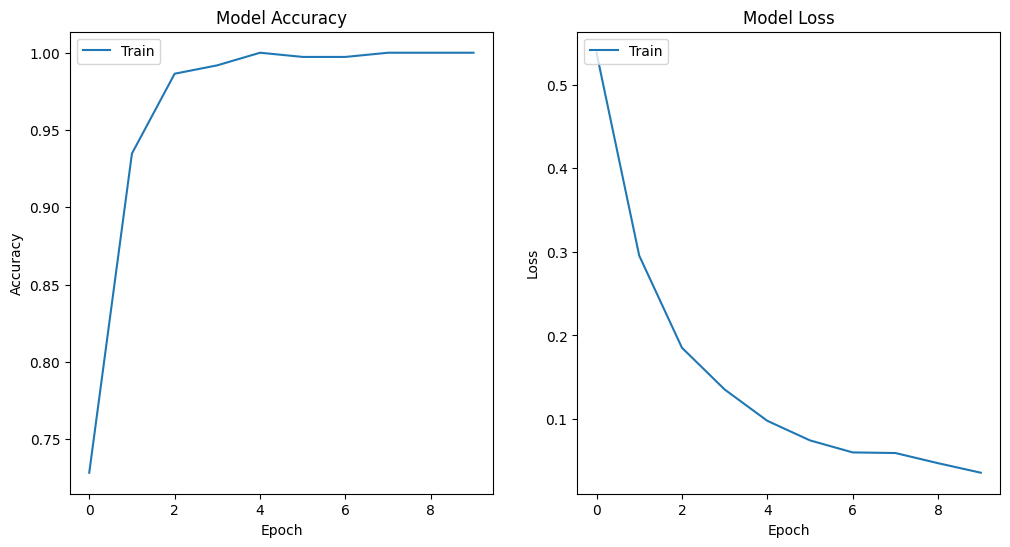

In [10]:
# Visualisasi grafik training akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(_.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(_.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Test video path: /content/drive/MyDrive/CNN/0/video_20240504_161249.mp4
1/1 [==============================] - 2s 2s/step
  0: 98.26%
  1:  1.74%


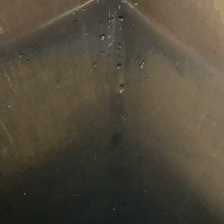

In [15]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    label = [0,1]
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    # probabilities = sequence_model.predict([frame_features, frame_mask])[0]
    model = tf.keras.models.load_model('/content/drive/MyDrive/CNN/model/cnn_rnn.h5')
    probabilities = model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    # print(converted_images)
    imageio.mimsave("/content/drive/MyDrive/CNN/dataset/animation.gif", converted_images, duration=100)
    return Image("/content/drive/MyDrive/CNN/dataset/animation.gif")


test_video = np.random.choice(test_df["nama_file"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [12]:
sequence_model.save("cnn_rnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
